# Direct Corrections for Deadtime on Cloud Simulations

This code compares the Mueller and Correlated Deadtime Correction (CDC) that leverages the "active fraction histogram" from my paper.

I also want to look at how this compares to ABLE's specs. 100-120 MHz clock (so minimum 8.3 ns range resolution). Also, simulated fluxes off the surface are around 10 MHz highest albedo, 3-4 MHz for dark surfaces. A deadtime value of 20 ns is realistic. They want to push it down to 8-9 ns. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
import torch
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

# import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

import fit_polynomial_utils_cloud as fit
import data_organize as dorg

eps = sys.float_info.epsilon

C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data

# Constants
c = 299792458  # [m/s] speed of light

# Parameters
home = str(Path.home())
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Cloud Measurements', 'Sims', 'saved_sims')
# load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Digitization Tests\Sims\saved_sims'

fname = r'simnum_12_amp_1.03E+09_nshot1.47E+04_useHGTrue_T0.95.nc'

ds = xr.open_dataset(os.path.join(load_dir, fname))

phot_events = ds.true_time_tag.values
dt_sim = ds.dt_sim.values  # [s]
t_sim_bins = ds.t_sim_bins.values  # [s]
Nshot = ds.sync_index.values[-1] + 1
det_events = ds.time_tag.values
det_sync_idx = ds.time_tag_sync_index
phot_sync_idx = ds.true_time_tag_sync_index
photon_rate_arr = ds.photon_rate_arr.values
tD = ds.dtime.values  # [s] deadtime
# f_L = ds.f_L.values  # [s]

In [3]:
det_events = np.array(det_events)
phot_events = np.array(phot_events)

det_events_ordered = []
phot_events_ordered = []
for i in range(Nshot):
    det_idx = np.where(np.array(det_sync_idx)==i)[0]
    phot_idx = np.where(np.array(phot_sync_idx)==i)[0]
    if det_idx.size == 0:
        det_events_ordered.append([])
    else:
        det_events_shot = det_events[det_idx]
        det_events_ordered.append(det_events_shot)
    if phot_idx.size == 0:
        phot_events_ordered.append([])
    else:
        phot_events_shot = phot_events[phot_idx]
        phot_events_ordered.append(phot_events_shot)

In [4]:
f_L = 14.7e3  # [Hz] laser rep rate
dR = dt_sim * c / 2  # [m]
alt_bins = t_sim_bins - 0.5*dR

range_avg = 1000
shot_avg = 14700

# Check that shot average is divisible by the number of shots
if Nshot % shot_avg != 0:
    print('Change "shot_avg" variable to divisible number!')
    
if type(shot_avg) != int:
    shot_avg = int(shot_avg)

In [5]:
dim_range = len(t_sim_bins[::range_avg][:-1])
curtain_det = np.zeros((dim_range, Nshot))
curtain_phot = np.zeros((dim_range, Nshot))
for i in range(Nshot):
    n, bins = np.histogram((np.array(det_events_ordered[i])*dt_sim), bins=t_sim_bins[::range_avg])
    curtain_det[:, i] = n[::-1]
    
    n, _ = np.histogram((np.array(phot_events_ordered[i])*dt_sim), bins=t_sim_bins[::range_avg])
    curtain_phot[:, i] = n[::-1]
    
rows, cols = curtain_det.shape
curtain_det = curtain_det.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)
curtain_phot = curtain_phot.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)

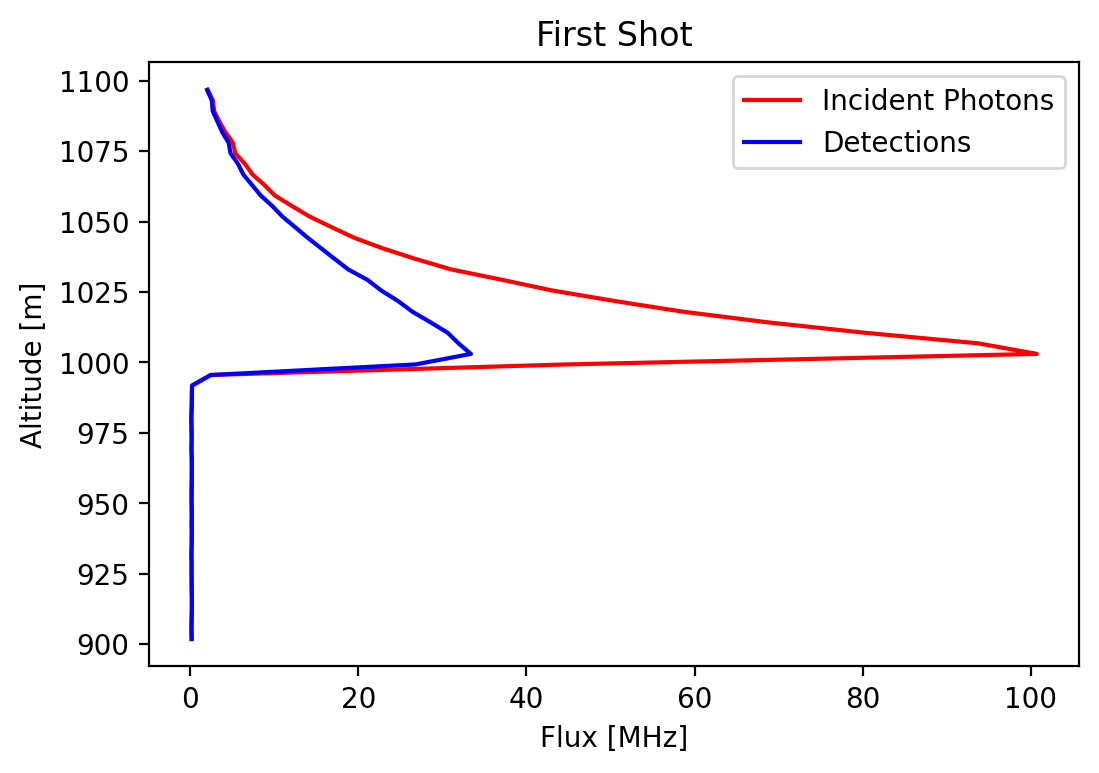

In [7]:
bwidth = np.diff(bins)[0]
centers = bins[:-1] + 0.5*bwidth  # [s]
centers = centers*c/2  # [m]

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(curtain_phot[:, 0][::-1]/shot_avg/bwidth/1e6, centers, 'r', label='Incident Photons')
ax.plot(curtain_det[:, 0][::-1]/shot_avg/bwidth/1e6, centers, 'b', label='Detections')
ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_title('First Shot')
plt.legend()
plt.show()

Range Resolution: 3.7474 m
Time Resolution: 1.0000 s


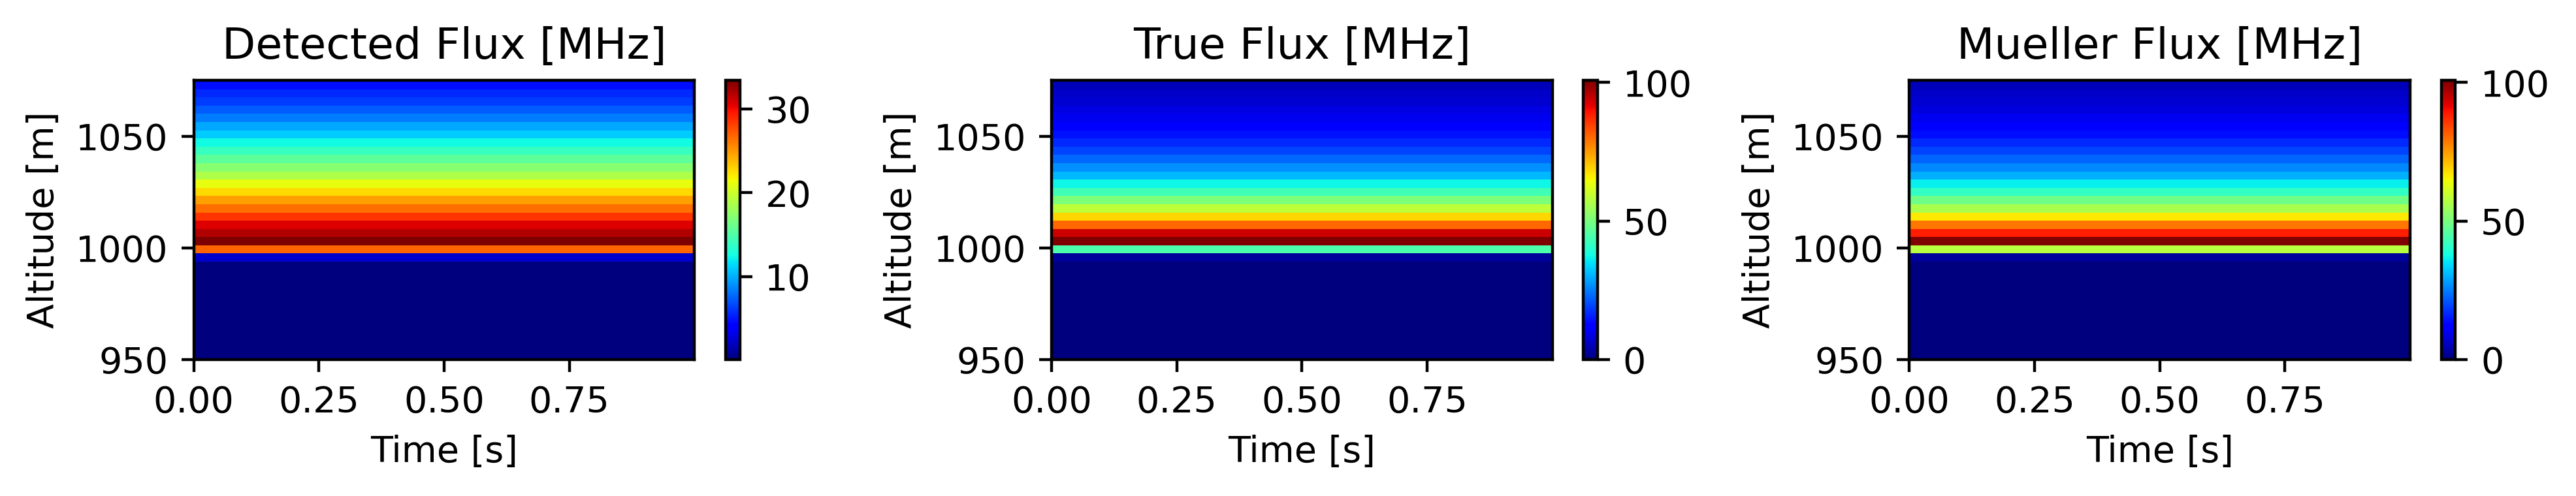

In [8]:
curtain_det_flux = curtain_det / bwidth / shot_avg  # [Hz] Detected flux
curtain_phot_flux = curtain_phot / bwidth / shot_avg  # [Hz] True flux
curtain_muller_flux = curtain_det_flux / (1-curtain_det_flux*tD)  # [Hz] Muller Corrected Flux
neg_vals = np.where(curtain_muller_flux < 0)
curtain_muller_flux[neg_vals] = np.nan

cmin_phot, cmax_phot = np.min(curtain_phot_flux), np.max(curtain_phot_flux)
cmin_det, cmax_det = np.min(curtain_det_flux), np.max(curtain_det_flux)
cmin_muller, cmax_muller = np.nanmin(curtain_muller_flux), np.nanmax(curtain_muller_flux)

print('Range Resolution: {:.4f} m'.format(bwidth*c/2))
print('Time Resolution: {:.4f} s'.format(shot_avg/f_L))

fig = plt.figure(figsize=(10,2), dpi=400)

ax = fig.add_subplot(131)
im = ax.imshow(curtain_det_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(cmin_det/1e6, cmax_det/1e6)
ax.set_title('Detected Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(132)
im = ax.imshow(curtain_phot_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('True Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(133)
im = ax.imshow(curtain_muller_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('Mueller Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1075])
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Now calculate CDC values

In [9]:
t_min = t_sim_bins[0]  # [s]
t_max = t_sim_bins[-1]  # [s]
window_bnd = [t_min, t_max]  # [s]

# calculate active fraction histogram
dsamp = 10
intgrl_N = int(len(t_sim_bins)/dsamp)  # number of bins in integral. I usually set this to the number of bins in the histogram for consistency
deadtime = tD  # [s] 

shot_avg = int(14700)
exclude_shots = True

# Check that shot average is divisible by the number of shots
if Nshot % shot_avg != 0:
    print('Change "shot_avg" variable to divisible number!')
    
if type(shot_avg) != int:
    shot_avg = int(shot_avg)
    
num_temporal_bins = Nshot / shot_avg
print('Number of temporal bins: {}'.format(num_temporal_bins))
print('Number of range bins: {}'.format(intgrl_N))

Number of temporal bins: 1.0
Number of range bins: 5337


In [145]:
avg_bins = 10
max_idx = (intgrl_N//avg_bins) * avg_bins
rmndr = intgrl_N - max_idx
print('Remainder range bins per column getting thrown away to average to coarser bins: {}'.format(rmndr))

cnts_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
muller_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
cdc_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
active_ratio_curtain = np.zeros((int(num_temporal_bins), intgrl_N))
for i in range(int(num_temporal_bins)):
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt_sim, load_dir, fname, window_bnd, shot_avg-1, exclude_shots, repeat_num=i+1)
    t_phot_fit_tnsr = flight_time.values
    n_shots += 1

    active_ratio_hst, AF_bin_edges = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
    active_ratio_hst = active_ratio_hst.detach().numpy()
    active_ratio_hst[np.where(active_ratio_hst==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
    active_ratio_curtain[i, :] = active_ratio_hst
    
    Y = np.histogram(t_phot_fit_tnsr, bins=AF_bin_edges)[0]
    cdc = Y / active_ratio_hst

    binwidth = np.diff(AF_bin_edges)[0]
    binwidth_smooth = binwidth * avg_bins

    # Raw counts
    Y_reshape = np.reshape(Y[:max_idx], (len(Y)//avg_bins, avg_bins))
    Y_smooth = np.sum(Y_reshape, axis=1)
    # CDC
    cdc_reshape = np.reshape(cdc[:max_idx], (len(cdc)//avg_bins, avg_bins))
    cdc_smooth_cnts = np.sum(cdc_reshape, axis=1)
    
    cnts_curtain[i, :] = Y_smooth / n_shots / binwidth_smooth  # [Hz]
    muller_curtain[i, :] = cnts_curtain[i, :] / (1-cnts_curtain[i, :]*deadtime)  # [Hz]
    cdc_curtain[i, :] = cdc_smooth_cnts / n_shots / binwidth_smooth  # [Hz]
    
    print('Time bin #{}'.format(i))
    
cnts_curtain = cnts_curtain.T[::-1]
muller_curtain = muller_curtain.T[::-1]
cdc_curtain = cdc_curtain.T[::-1]

Remainder range bins per column getting thrown away to average to coarser bins: 7
Time bin #0


In [146]:
# set up the truth curtain
dim_range = len(t_sim_bins[::range_avg][:-1])
curtain_truth = np.zeros((intgrl_N//avg_bins, Nshot))
for i in range(Nshot):    
    n, _ = np.histogram((np.array(phot_events_ordered[i])*dt_sim), bins=AF_bin_edges[::avg_bins])
    curtain_truth[:, i] = n[::-1]
    
rows, cols = curtain_truth.shape
curtain_truth = curtain_truth.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)

curtain_truth_flux = curtain_truth / n_shots / binwidth_smooth 

Range binwidth: 0.37 m


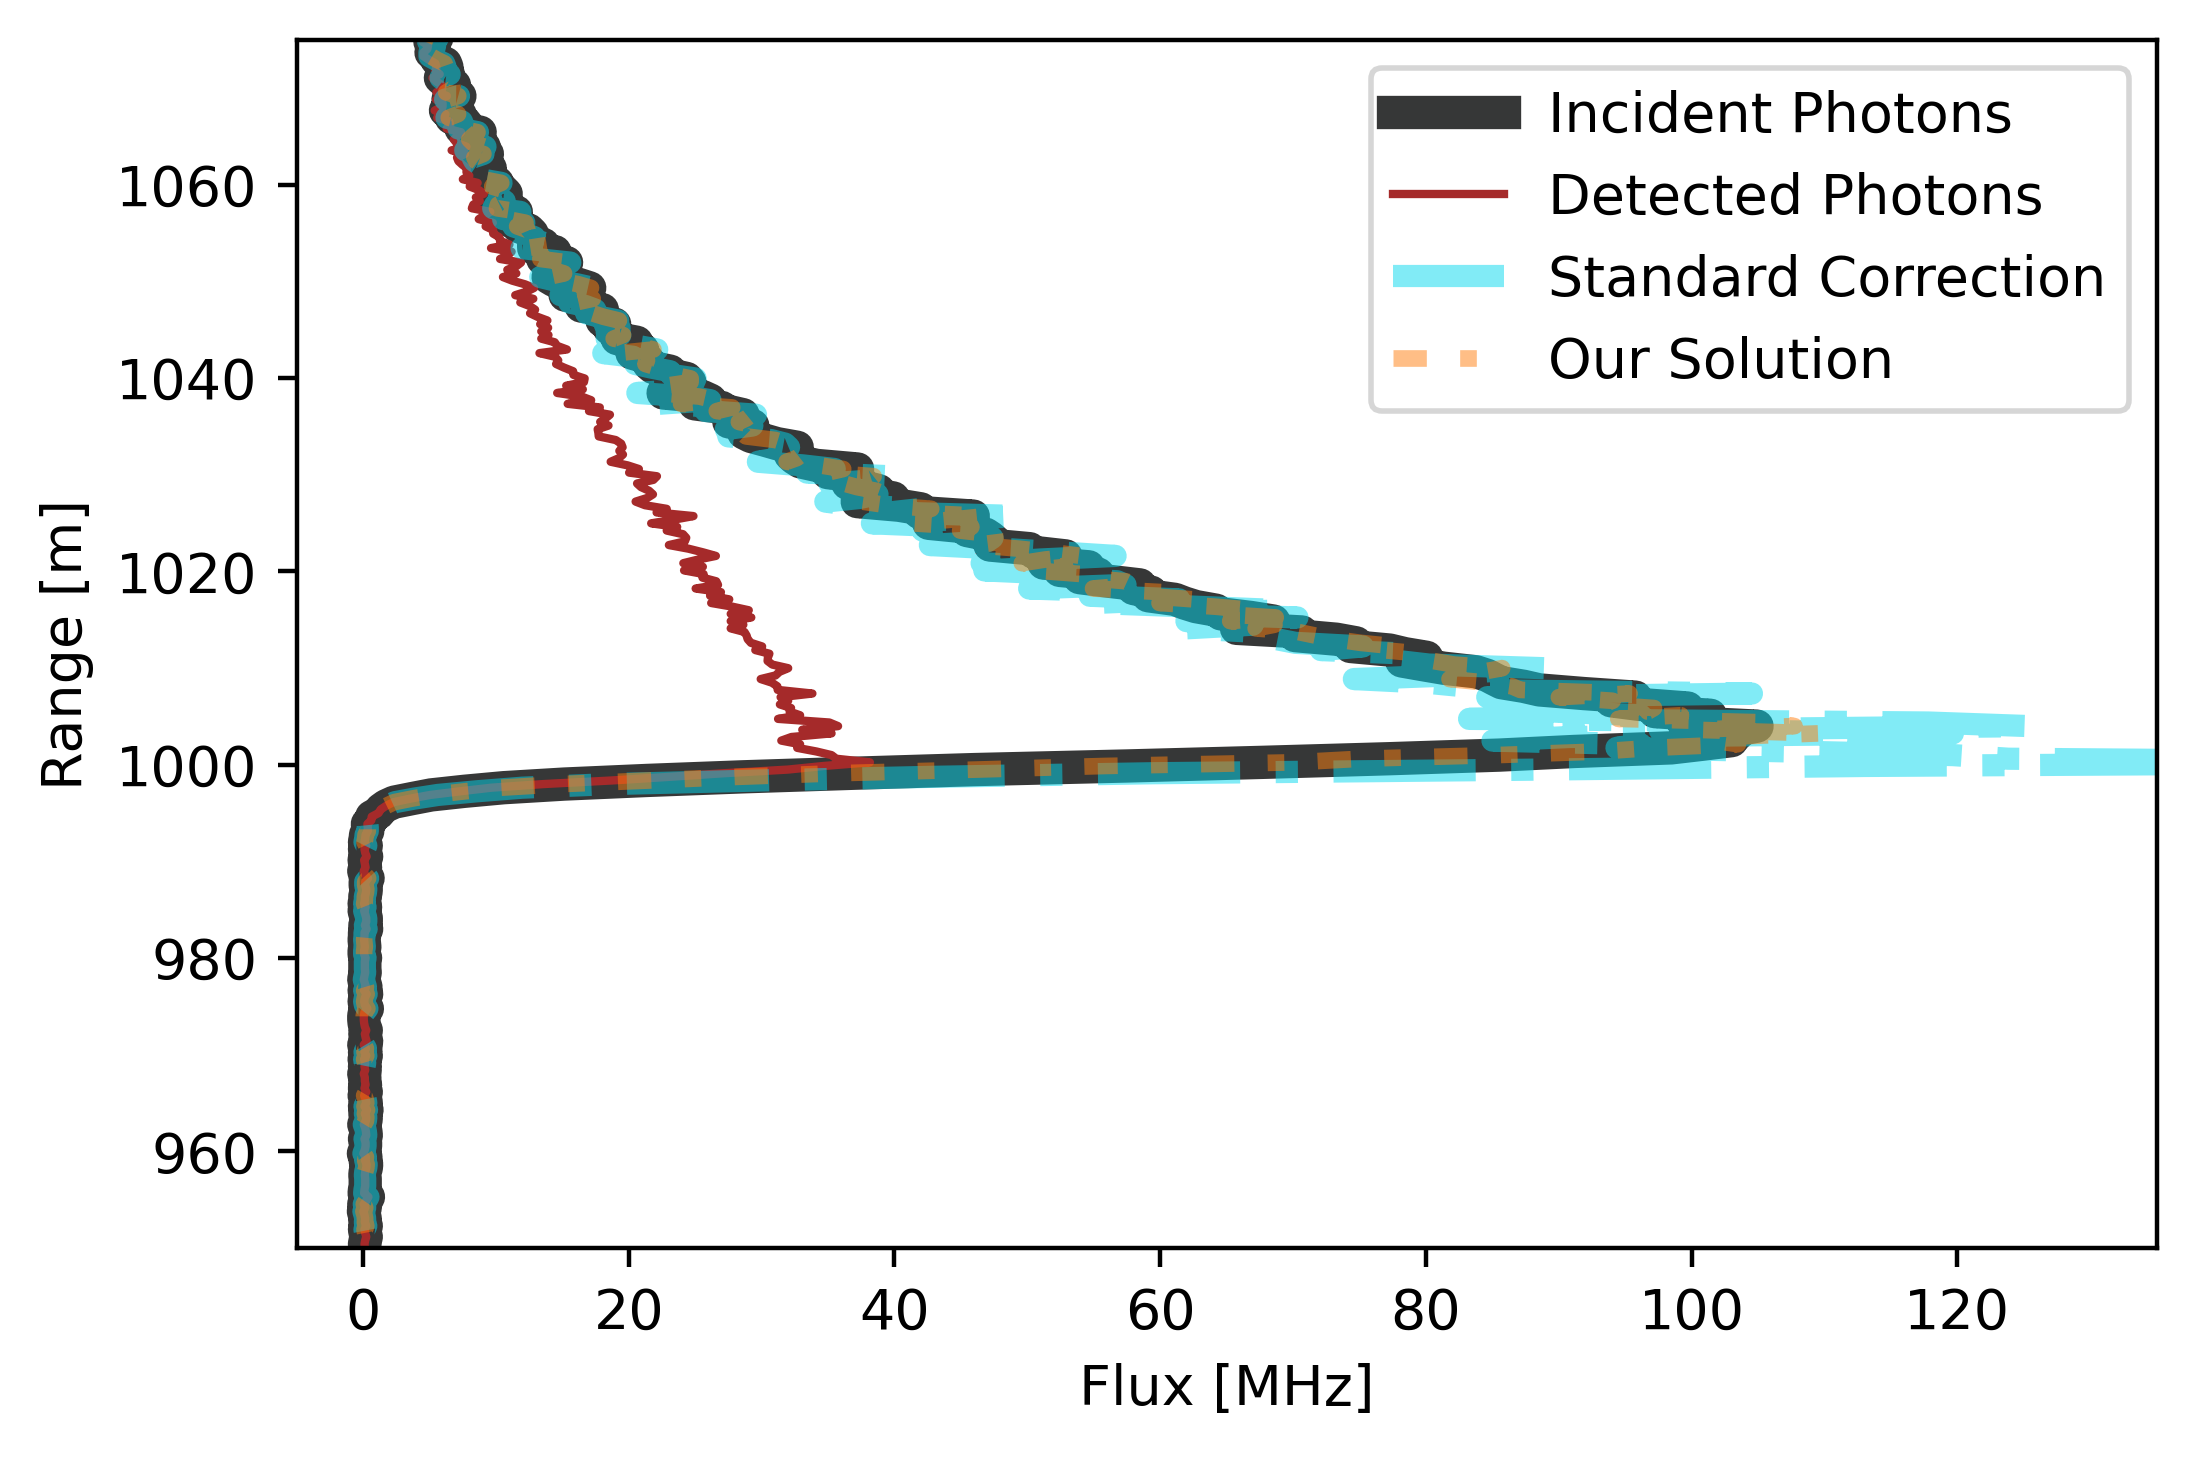

In [150]:
t_plot = np.arange(window_bnd[0]+binwidth_smooth/2, window_bnd[1]-binwidth_smooth/2, binwidth_smooth)
range_plot = t_plot * c / 2  # [m]
print('Range binwidth: {:.2f} m'.format(binwidth_smooth*c/2))

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(curtain_truth_flux[:, 0][::-1]/1e6, range_plot, label='Incident Photons', alpha=1, color='#363737', linewidth=6)
ax.plot(cnts_curtain[:, 0][::-1]/1e6, range_plot, label='Detected Photons', color='brown')
ax.plot(muller_curtain[:, 0][::-1]/1e6, range_plot, label='Standard Correction', alpha=0.5, linestyle='-.', color='#04d9ef', linewidth=4)
ax.plot(cdc_curtain[:, 0][::-1]/1e6, range_plot, label='Our Solution', alpha=0.5, linestyle=(0, (2, 2, 1, 2)), linewidth=3, color='C1')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([950, 1075])
# ax.set_title('First Shot')
# ax.set_xscale('log')
ax.set_xlim([-5, 135])
plt.legend()
plt.show()

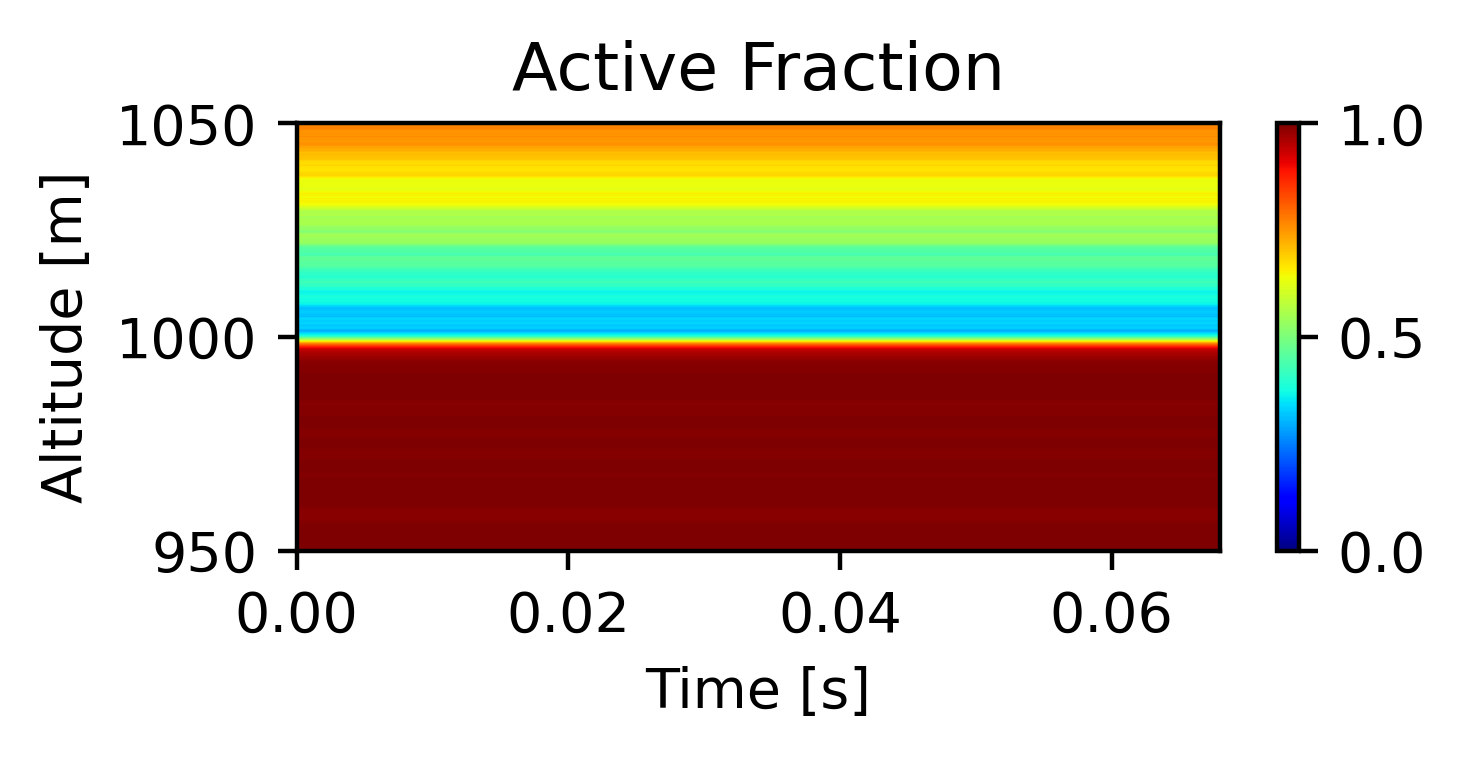

In [79]:
fig = plt.figure(figsize=(10,2), dpi=400)

ax = fig.add_subplot(131)
im = ax.imshow(active_ratio_curtain.T[::-1], aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, 1)
ax.set_title('Active Fraction')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)
plt.tight_layout()
plt.show()

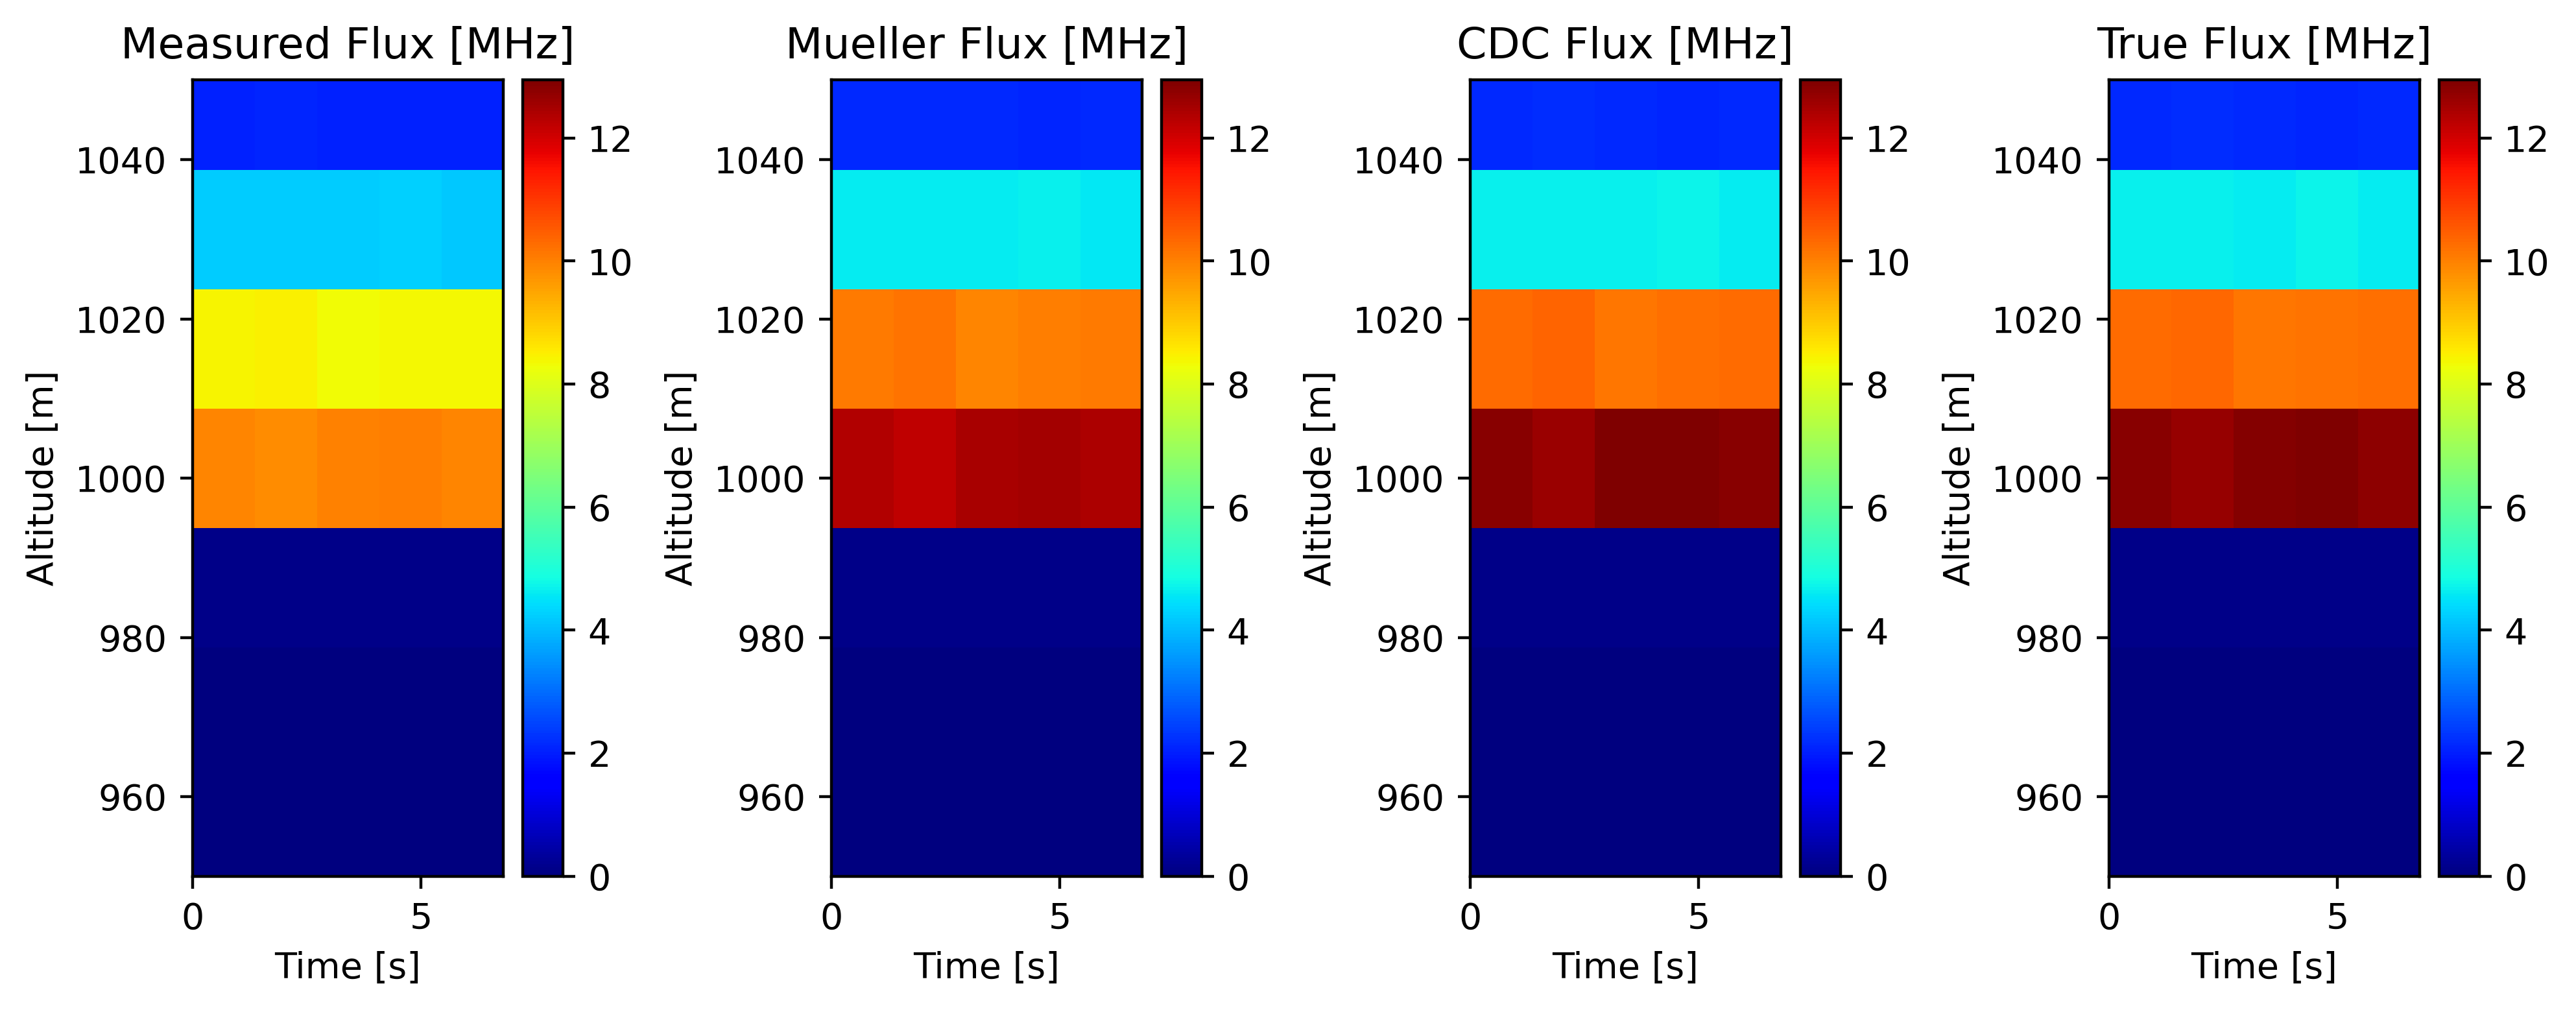

In [13]:
cmax_phot = np.max(curtain_truth_flux)

fig = plt.figure(figsize=(10,4), dpi=400)

ax = fig.add_subplot(141)
im = ax.imshow(cnts_curtain/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('Measured Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)

ax = fig.add_subplot(142)
im = ax.imshow(muller_curtain/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('Mueller Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)

ax = fig.add_subplot(143)
im = ax.imshow(cdc_curtain/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('CDC Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)

ax = fig.add_subplot(144)
im = ax.imshow(curtain_truth_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, cmax_phot/1e6)
ax.set_title('True Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)
plt.tight_layout()
plt.show()

# GRAVEYARD

In [147]:
Y_curtain = []
active_ratio_hst_curtain = []
for i in range(int(num_temporal_bins)):
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt_sim, load_dir, fname, window_bnd, shot_avg-1, exclude_shots, repeat_num=i+1)
    t_phot_fit_tnsr = flight_time.values
    n_shots += 1

    active_ratio_hst, AF_bin_edges = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
    active_ratio_hst = active_ratio_hst.detach().numpy()
    active_ratio_hst[np.where(active_ratio_hst==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
    if i == 0:
        t_bins = AF_bin_edges[:-1] + 0.5*np.diff(AF_bin_edges)[0]
        binwidth = np.diff(AF_bin_edges)[0]
        t_intgrl = torch.tensor(t_bins)  # [s]
        
        print('Acquisition binwidth: {:.2E}'.format(binwidth))

    Y = np.histogram(t_phot_fit_tnsr, bins=AF_bin_edges)[0]
    
    Y_curtain.append(Y)
    active_ratio_hst_curtain.append(active_ratio_hst)
    
    print('Bin #{}'.format(i))
    
Y_curtain = np.array(Y_curtain).T[::-1]
active_ratio_hst_curtain = np.array(active_ratio_hst_curtain).T[::-1]

Acquisition binwidth: 2.50E-10
Bin #0
Bin #1
Bin #2
Bin #3
Bin #4


In [140]:
# Let's apply the Mueller and Inst. Deadtime Corrections to the profiles

muller = (1/n_shots/binwidth) * Y_curtain/(1-Y_curtain/n_shots/binwidth*deadtime)  # [Hz]
dinst = (1/n_shots/binwidth) * Y_curtain/active_ratio_hst_curtain  # [Hz]
raw = (1/n_shots/binwidth) * Y_curtain  # [Hz]

dinst[np.where(dinst==np.inf)[0]] = np.nan  # if inf value, set to highest number instead

bins = AF_bin_edges
center = 0.5 * (bins[:-1] + bins[1:])

In [ ]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(t_intgrl*c/2, dinst[:, 4]/1e6, label='CDC')
ax.plot(t_intgrl*c/2, muller[:, 4]/1e6, label='Muller')
ax.plot(t_intgrl*c/2, raw[:, 4]/1e6, label='Detections')
ax.set_xlabel('Range [m]')
ax.set_ylabel('Flux [MHz]')
plt.legend()
plt.show()

In [114]:
avg_bins = 1000
binwidth_smooth = binwidth * avg_bins

max_idx = (len(raw)//avg_bins) * avg_bins
rmndr = len(raw) - max_idx  # remainder to discard (make sure this is a small number)
print('Remainder bins per column getting thrown away to average to coarser bins: {}'.format(rmndr))

row_smooth, col_smooth = raw[:max_idx].shape

# Raw counts
raw_reshape = np.reshape(raw[:max_idx], (row_smooth//avg_bins, col_smooth, avg_bins))
raw_smooth = np.sum(raw_reshape, axis=2) / avg_bins
# CDC counts
dinst_reshape = np.reshape(dinst[:max_idx], (row_smooth//avg_bins, col_smooth, avg_bins))
dinst_smooth = np.sum(dinst_reshape, axis=2) / avg_bins
# Mueller counts
muller_reshape = np.reshape(muller[:max_idx], (row_smooth//avg_bins, col_smooth, avg_bins))
muller_smooth = np.sum(muller_reshape, axis=2) / avg_bins

Remainder bins per column getting thrown away to average to coarser bins: 337


In [116]:
dim_range = len(t_sim_bins[::range_avg][:-1])
curtain_phot = np.zeros((dim_range, Nshot))
for i in range(Nshot):    
    n, _ = np.histogram((np.array(phot_events_ordered[i])*dt_sim), bins=t_sim_bins[::range_avg])
    curtain_phot[:, i] = n[::-1]
    
rows, cols = curtain_phot.shape
curtain_phot = curtain_phot.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)

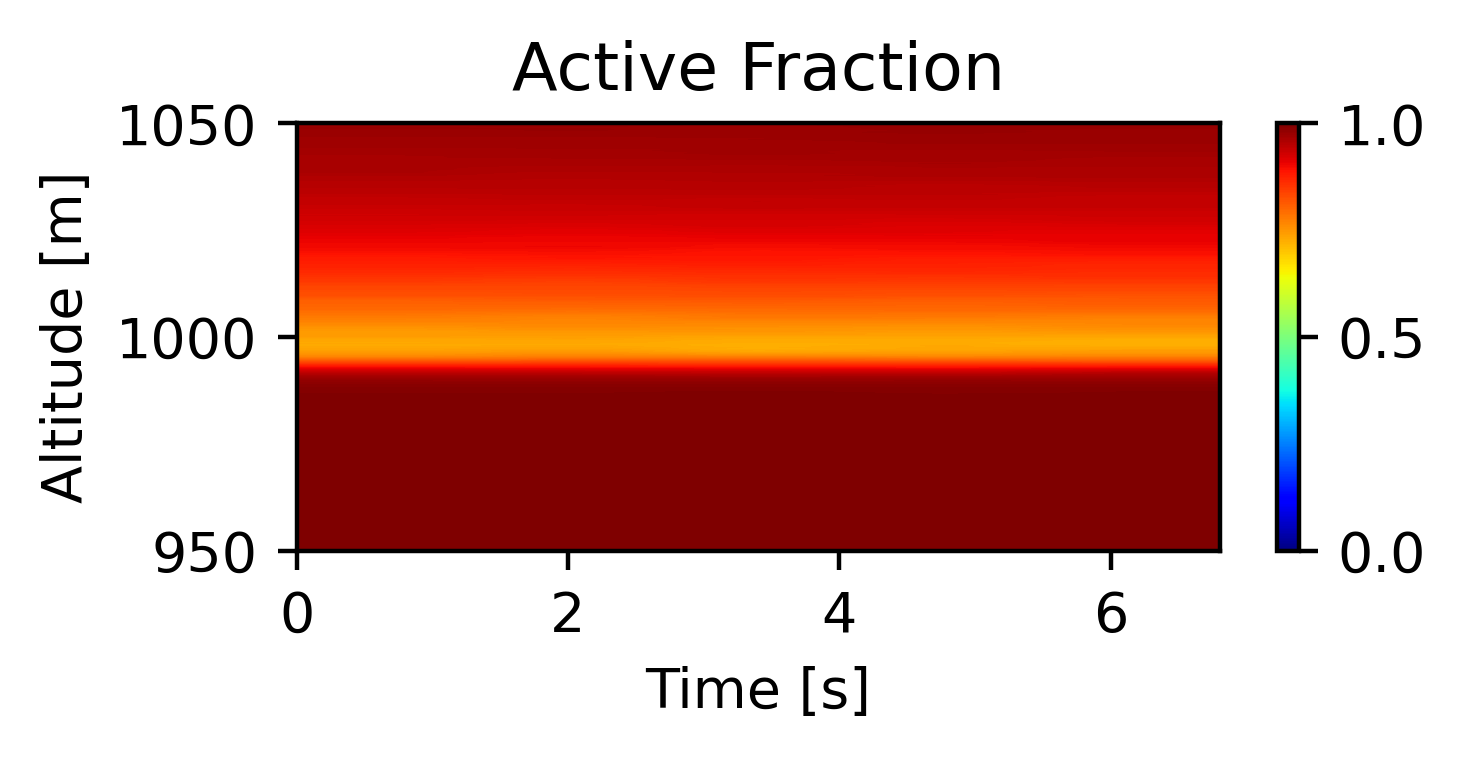

In [117]:
fig = plt.figure(figsize=(10,2), dpi=400)

ax = fig.add_subplot(131)
im = ax.imshow(active_ratio_hst_curtain, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
im.set_clim(0, 1)
ax.set_title('Active Fraction')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([950, 1050])
plt.colorbar(im)
plt.tight_layout()
plt.show()

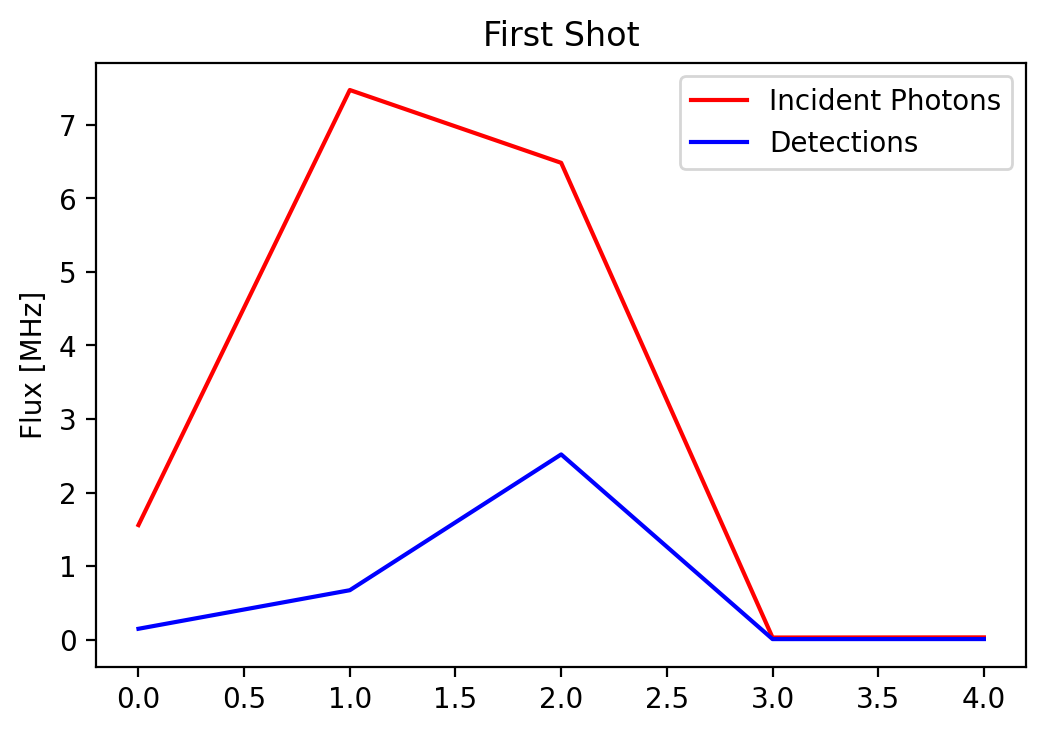

In [139]:
# bwidth = np.diff(bins)[0]
# centers = bins[:-1] + 0.5*bwidth  # [s]
# centers = centers*c/2  # [m]

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(curtain_phot_flux[:, 0]/1e6, 'r', label='Incident Photons')
ax.plot(raw_smooth[:, 0]/1e6, 'b', label='Detections')
# ax.set_ylabel('Altitude [m]')
ax.set_ylabel('Flux [MHz]')
ax.set_title('First Shot')
plt.legend()
plt.show()

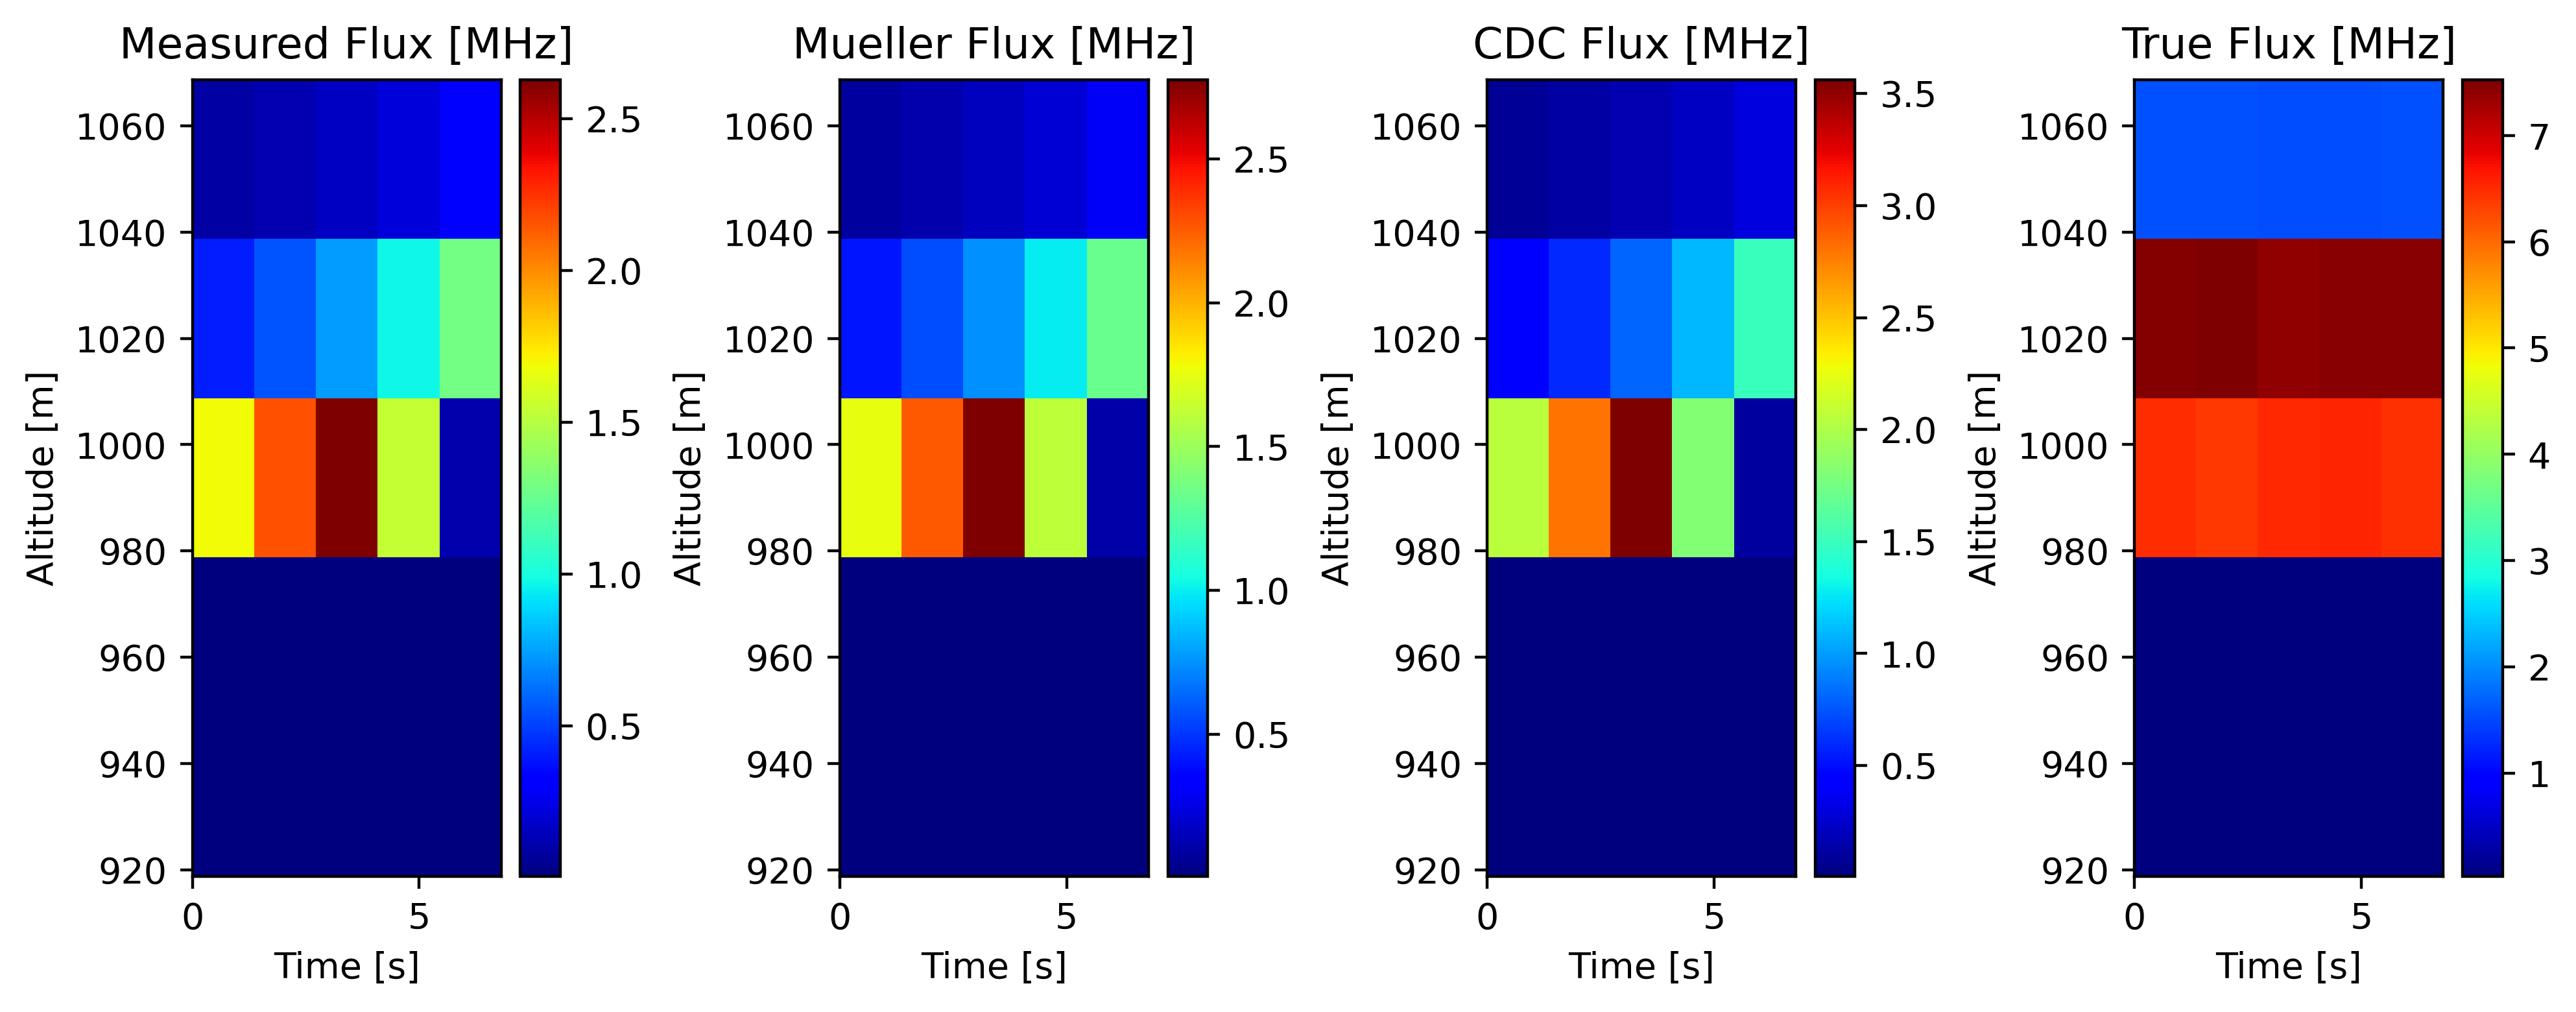

In [106]:
fig = plt.figure(figsize=(10,4), dpi=400)

ax = fig.add_subplot(141)
im = ax.imshow(raw_smooth/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
# im.set_clim(0, 1)
ax.set_title('Measured Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1050])
plt.colorbar(im)

ax = fig.add_subplot(142)
im = ax.imshow(muller_smooth/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
# im.set_clim(0, cmax_phot/1e6)
ax.set_title('Mueller Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(143)
im = ax.imshow(dinst_smooth/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
# im.set_clim(0, cmax_phot/1e6)
ax.set_title('CDC Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)

ax = fig.add_subplot(144)
im = ax.imshow(curtain_phot_flux/1e6, aspect='auto', extent=[0/f_L, (Nshot-1)/f_L, np.min(centers), np.max(centers)], cmap='jet')
# im.set_clim(0, cmax_phot/1e6)
ax.set_title('True Flux [MHz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Altitude [m]')
# ax.set_ylim([950, 1075])
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [108]:
# fig = plt.figure(dpi=400, facecolor='w', figsize=(8,3))
# ax = fig.add_subplot(111)

# # ax.barh(center*c/2, muller/1e6, align='center', height=binwidth*c/2, color='m', alpha=1, label='Mueller')
# # ax.barh(center*c/2, dinst/1e6, align='center', height=binwidth*c/2, color='g', alpha=0.75, label='Inst.')
# # ax.barh(center*c/2, raw/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.5, label='Measured')

# # ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')

# ax.barh(center*c/2, active_ratio_hst, align='center', height=binwidth*c/2, color='r', alpha=0.75)

# ax.set_ylabel('Range [m]')
# ax.set_xlabel('Active Fraction')
# # ax.set_xlim([0.01, 100])
# # ax.set_ylim([950, 1150])
# # ax.set_xscale('log')
# # plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

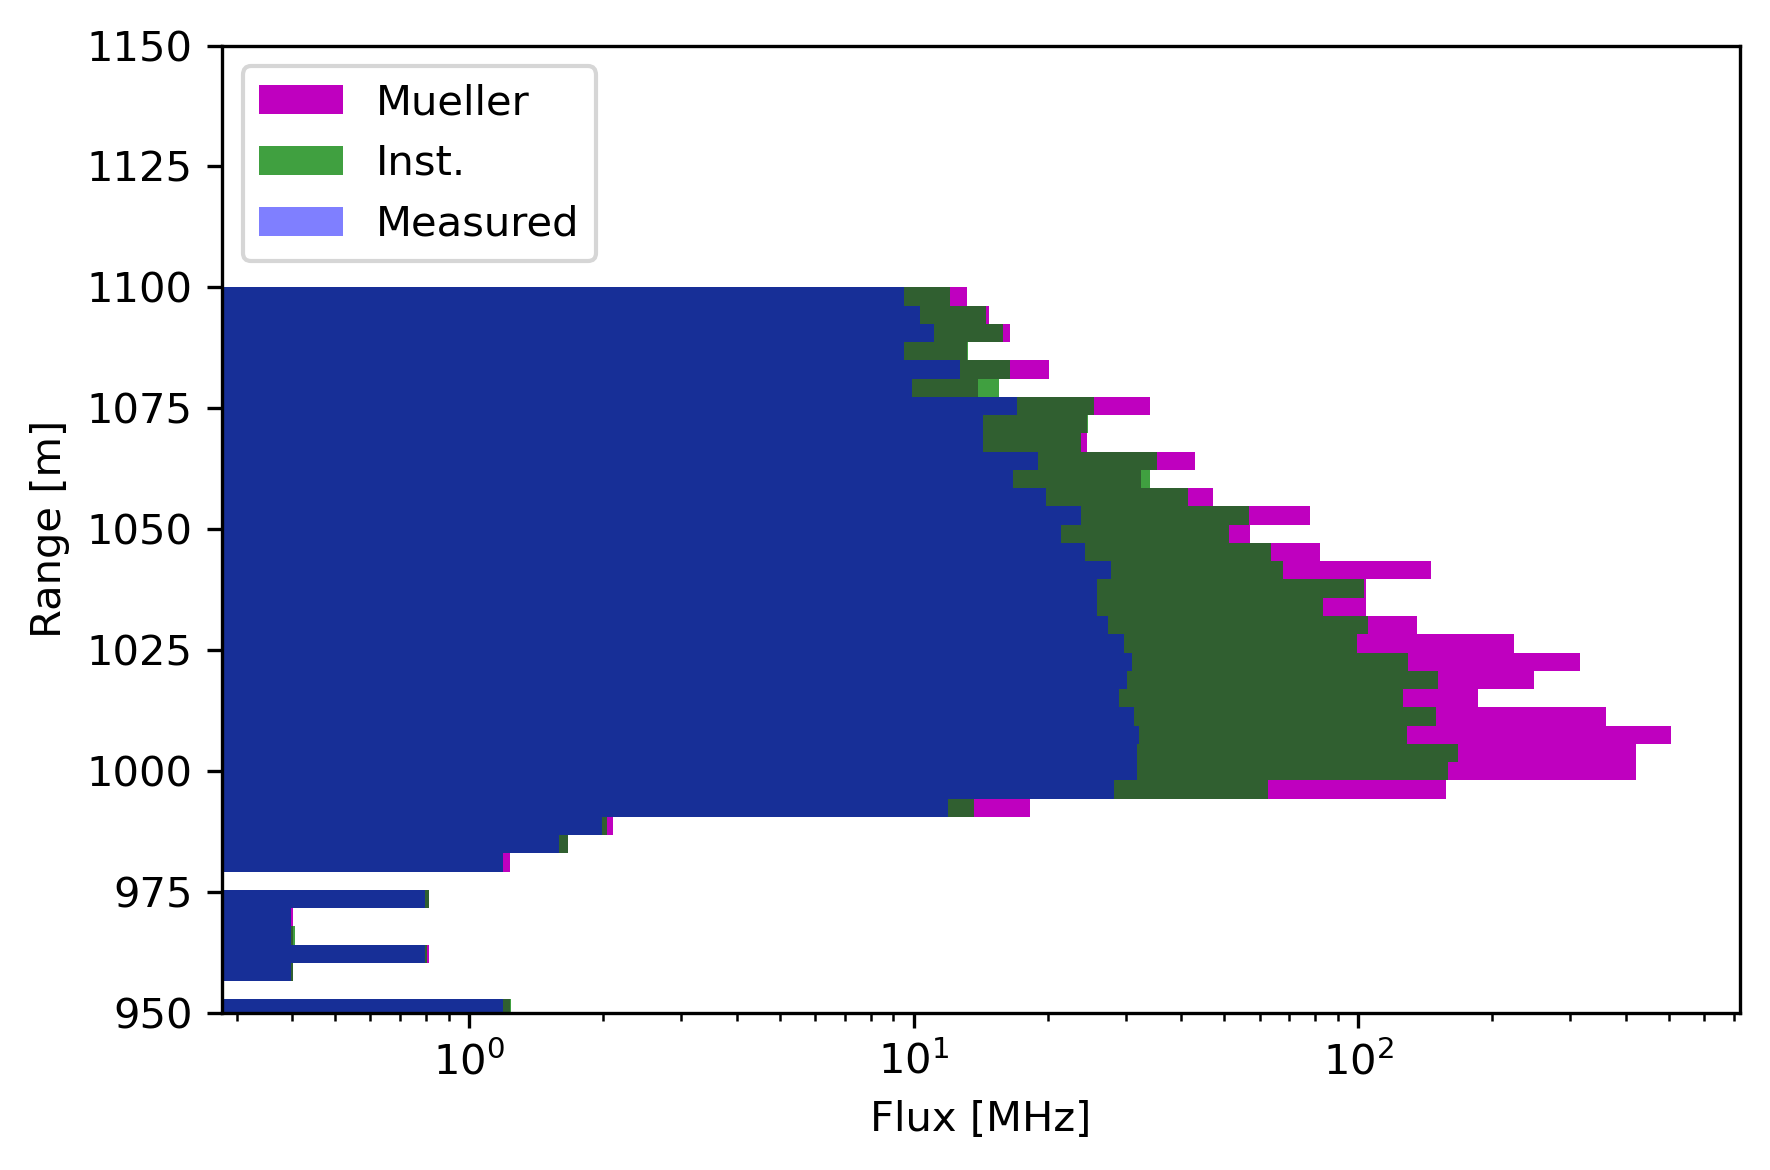

In [68]:
if binwidth<=100e-12:
    print('Restarting kernel b/c plotting would have taken too long...')
    quit()

fig = plt.figure(dpi=300, facecolor='w')
ax = fig.add_subplot(111)

ax.barh(center*c/2, muller/1e6, align='center', height=binwidth*c/2, color='m', alpha=1, label='Mueller')
ax.barh(center*c/2, dinst/1e6, align='center', height=binwidth*c/2, color='g', alpha=0.75, label='Inst.')
ax.barh(center*c/2, raw/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.5, label='Measured')

# ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')

ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
# ax.set_xlim([0.01, 100])
ax.set_ylim([950, 1150])
ax.set_xscale('log')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()